<a href="https://colab.research.google.com/github/djliden/numerai/blob/main/notebooks/fastai_tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular Learner with Fastai

The goal of this notebook is to implement a tabular deep learning model using fastai and submit to this week's competition. I eventually plan to build this out into a more structured and modular PyTorch project, but for now I want to make sure that this works and will generate reasonable results.

There's a lot to explore -- such as choice of loss function and evaluation metri [link](https://forum.numer.ai/t/model-evaluation-metrics/337) -- but we're keeping it simple for now.

## Dependencies and Data Download

In [5]:
# install
!pip install --upgrade python-dotenv fastai numerapi

# import dependencies
import os
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import numpy as np
import numerapi
from fastai.tabular.all import *

# Secrets setup
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
public_key = os.environ.get("NUMERAI_PUBLIC_KEY")
private_key = os.environ.get("NUMERAI_PRIVATE_KEY")

napi = numerapi.NumerAPI(verbosity="info", public_id=public_key, secret_key=private_key)
napi.download_current_dataset(dest_path="../input/", unzip=True)

     |████████████████████████████████| 194kB 5.9MB/s 
     |████████████████████████████████| 61kB 4.7MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


../input/numerai_dataset_252.zip: 100%|█████████▉| 391M/392M [00:25<00:00, 17.7MB/s]2021-02-25 23:09:32,323 INFO numerapi.base_api: unzipping file...
../input/numerai_dataset_252.zip: 392MB [00:39, 17.7MB/s]                           

'../input/numerai_dataset_252.zip'

## Data Setup

In [8]:
filename = "../input/numerai_dataset_252/numerai_tournament_data.csv"
chunksize = 100000
iter_csv = pd.read_csv(filename, iterator=True, chunksize=chunksize)
val_df = pd.concat([chunk[chunk['data_type'] == 'validation'] for chunk in iter_csv])
val_df.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,0.25,0.50,0.5,0.25,0.0,0.25,0.50,0.25,0.00,0.25,1.00,1.00,0.25,1.00,1.00,0.25,0.25,0.0,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.00,...,0.00,0.0,0.25,0.5,0.25,0.25,0.00,0.25,0.00,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.5,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,0.75,0.25,0.0,0.75,0.5,0.00,0.25,0.50,0.00,1.00,0.25,0.25,1.00,1.00,0.25,0.75,0.00,0.0,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.00,...,0.50,0.5,0.25,1.0,0.50,0.25,0.00,0.25,0.50,0.25,1.00,0.25,0.00,0.50,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.50,0.50,0.5,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,1.00,0.50,0.5,1.00,1.0,1.00,0.75,0.50,0.50,1.00,1.00,0.50,0.50,0.00,1.00,0.50,1.00,0.5,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.00,...,0.25,0.5,0.00,0.0,0.00,0.25,0.25,0.00,0.50,0.00,0.00,0.00,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.75,0.0,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,0.50,0.75,1.0,0.75,0.0,0.50,0.00,0.50,0.75,0.50,0.75,0.25,0.75,0.25,0.75,0.25,0.75,1.0,0.50,0.50,0.75,0.50,1.00,0.50,0.25,0.75,0.25,0.75,0.25,0.75,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.75,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,0.25,0.25,0.5,0.50,1.0,1.00,1.00,1.00,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.00,0.25,0.0,0.00,0.75,0.25,1.00,0.25,1.00,0.75,0.00,1.00,0.75,0.75,0.75,...,0.00,0.5,0.50,0.0,0.75,0.50,0.75,0.25,0.25,0.25,0.00,0.25,0.50,0.25,1.00,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.75,1.00,1.0,0.75,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,0.75


In [9]:
training_data = pd.read_csv("../input/numerai_dataset_252/numerai_training_data.csv")
training_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.00,0.75,0.5,1.0,0.5,0.00,0.50,0.50,0.00,0.0,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.5,0.50,0.75,0.5,...,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.5,0.25,0.25,0.75,0.50,1.00,0.5,0.75,0.75,0.25,0.50,1.00,0.75,0.50,0.50,1.00,0.25,0.5,0.50,0.50,0.75,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.00,0.50,0.5,0.5,0.5,0.50,0.25,0.25,0.50,0.0,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.5,0.25,0.75,0.5,...,0.25,0.25,0.25,1.00,1.00,0.50,0.50,0.50,0.0,0.25,1.00,0.50,1.00,1.00,0.5,0.50,0.50,1.00,0.25,0.75,1.00,0.25,0.25,1.00,0.50,0.5,0.50,0.75,0.75,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.50,0.75,0.5,0.5,1.0,0.50,0.50,0.50,0.25,0.0,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.5,0.50,0.75,0.5,...,0.25,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.5,1.00,0.00,1.00,1.00,0.50,1.0,0.75,1.00,0.00,0.50,0.75,0.00,1.00,0.50,0.50,0.75,1.0,0.75,1.00,0.25,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,1.0,0.5,0.5,0.00,1.00,0.00,0.75,0.0,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.5,0.50,0.50,0.5,...,1.00,1.00,0.75,0.75,1.00,0.75,0.75,0.75,1.0,0.75,1.00,0.75,1.00,0.75,1.0,0.00,0.50,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.00,0.5,0.75,0.75,1.00,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,0.25,0.25,0.50,0.25,0.25,0.75,0.50,0.0,0.5,0.5,0.25,0.00,0.50,0.00,0.5,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.50,0.25,0.5,0.50,0.50,0.5,...,1.00,0.25,0.75,1.00,0.75,0.00,0.00,0.75,0.5,1.00,0.50,0.75,0.25,0.50,0.0,0.50,0.50,0.50,0.75,0.75,0.50,0.75,0.25,0.75,0.50,0.5,0.25,0.25,0.75,0.50,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [10]:
training_data = pd.concat([training_data, val_df])
training_data.reset_index(drop=True, inplace=True)

In [11]:
feature_cols = training_data.columns[training_data.columns.str.startswith('feature')]
target_cols = ['target']

In [12]:
train_idx, test_idx = training_data.index[training_data.data_type=='train'].tolist(),training_data.index[training_data.data_type=='validation'].tolist()
splits = (list(train_idx), list(test_idx))
#train_idx, test_idx

In [13]:
categorical = ['era']
data = TabularPandas(training_data, cat_names=None,
                    cont_names=list(feature_cols.values),
                    y_names=target_cols, splits = splits)
len(data.train), len(data.valid)

(501808, 137779)

In [14]:
dls = data.dataloaders()

In [15]:
learn = tabular_learner(dls, layers=[200,100],
                        loss_func=MSELossFlat(),
                        metrics = [PearsonCorrCoef()])
#learn.lr_find()

In [17]:
learn.fit_one_cycle(1, wd = 2)

epoch,train_loss,valid_loss,pearsonr,time
0,0.051871,0.049952,0.012896,02:29


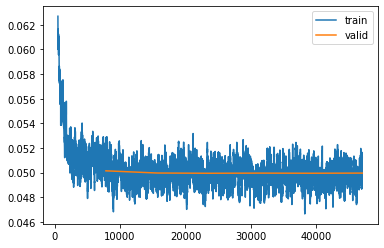

In [ ]:
learn.recorder.plot_loss(skip_start = 500)

In [ ]:
from scipy.stats import spearmanr
  
def sharpe(df: pd.DataFrame) -> np.float32:
    """
    Calculate the Sharpe ratio by using grouped per-era data
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: The Sharpe ratio for your predictions.
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """ Calculate Spearman correlation for Pandas' apply method """
        return spearmanr(sub_df["target"],  sub_df["prediction"])[0]
    corrs = df.groupby("era").apply(_score)
    return corrs.mean() / corrs.std()

# Would like to make this a metric that can be tracked with
# fastai but am not sure how.
prediction, target = learn.get_preds()
prediction = prediction.numpy().squeeze()
target = target.numpy().squeeze()
prediction, target

era = dls.valid_ds.items['era']
eval_df = pd.DataFrame({'prediction':prediction, 'target':target, 'era':era}).reset_index()
spearmanr(eval_df.target, eval_df.prediction)

sharpe(eval_df)

0.6429251290222179

In [ ]:
def build_submission(dls, learner,
                     chunk = True,
                     chunksize = 10000,
                     test_features):
  preds = []
  ids = []
  learn = learner
  if chunk:
    iter_csv = pd.read_csv(filename, iterator=True, chunksize=chunksize)
    preds.extend()
val_df = pd.concat([chunk[chunk['data_type'] == 'validation'] for chunk in iter_csv])
val_df.head()


class FastSubmission:
  '''Class for generating numerai submissions from fastai learners'''

  def __init__(self, dls, learner, chunk:bool, chunksize,
               test_data, test_features):
    self.dls = dls
    self.learn = learner
    self.chunk = True
    self.chunksize = chunksize
    self.test_features = test_features

  def get_preds_and_ids(self, data_subset):
    test_dl = self.dls.test_dl(data_subset)
    preds_out,_ = self.learn.get_preds(dl = test_dl, inner = True)
    ids_out = data_subset["id"]
  
  def build_sub(self):
    out_list = []
    if chunk:
      iter_csv = pd.read_csv(filename, iterator=True, chunksize=chunksize)
      out_list.extend([self.get_preds_and_ids(x) for x in iter_csv])
    else:
      pred_data = pd.read_csv(filename)
      out_list.extend(self.get_preds_and_ids(pred_data))
    
    return(out_list)





In [18]:
ids = []
preds = []

filename = "../input/numerai_dataset_252/numerai_tournament_data.csv"
chunksize = 100000
with pd.read_csv(filename, chunksize=chunksize) as reader:
    for chunk in reader:
        chunk.target = None
        test_dl = dls.test_dl(chunk[feature_cols])
        out,_ = learn.get_preds(dl=test_dl, inner=True)
        #test_df = chunk[feature_cols]
        #preds = learn.pred_batch(test_df)
        out = out.tolist()
        ids.extend(chunk["id"])
        preds.extend(out)

AttributeError: ignored

In [ ]:
len(preds)

1649775

In [ ]:
preds = [item for sublist in preds for item in sublist]

In [ ]:
preds[0:10], ids[0:10], len(preds), len(ids)

([0.49069294333457947,
  0.4867575168609619,
  0.5207219123840332,
  0.5003780126571655,
  0.49850523471832275,
  0.5043054223060608,
  0.49632760882377625,
  0.49158236384391785,
  0.49540552496910095,
  0.48753824830055237],
 ['n0003aa52cab36c2',
  'n000920ed083903f',
  'n0038e640522c4a6',
  'n004ac94a87dc54b',
  'n0052fe97ea0c05f',
  'n00a5ccf3b6b2870',
  'n00bf78d0bbbc1b6',
  'n00c6fd95ff0c83e',
  'n00cd56868258aec',
  'n00e7d6fb71ef69f'],
 1649775,
 1649775)

In [ ]:
# predictions must have an `id` column and a `prediction_kazutsugi` column
predictions_df = pd.DataFrame({
    'id':ids,
    'prediction_kazutsugi':preds
})
predictions_df.head()

,id,prediction_kazutsugi
0,n0003aa52cab36c2,0.490693
1,n000920ed083903f,0.486758
2,n0038e640522c4a6,0.520722
3,n004ac94a87dc54b,0.500378
4,n0052fe97ea0c05f,0.498505


In [ ]:
predictions_df.to_csv("../output/predictions.csv", index=False)
# Upload predictions
submission_id = napi.upload_predictions("../output/predictions.csv",
                                        model_id=os.environ.get("NUMERAI_MODEL_ID"))

2021-02-15 15:42:12,812 INFO numerapi.base_api: uploading predictions...
2021-02-15 15:43:02,959 ERROR numerapi.base_api: Can't update submission after deadline if previous submission was on time


ValueError: Can't update submission after deadline if previous submission was on time